In [113]:
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
# data visualisation and manipulation
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image

import matplotlib.pyplot as plt
import scipy.misc

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [98]:
train_a_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing_new/train/cover'
train_b_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing_new/train/stego'
#test_a_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing_new/test/cover'
test_b_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing_new/test/stego'
valid_a_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing_new/valid/cover'
valid_b_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing_new/valid/stego'

In [99]:
def assign_label(img,img_class):
    return img_class

In [100]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [101]:
X = []
Z = []
X1 = []
Z1 = []
X2 = []
Z2 = []
def make_train_data(img_class,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,img_class)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        #=img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
def make_test_data(img_class,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,img_class)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X1.append(np.array(img))
        Z1.append(str(label))
def make_valid_data(img_class,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,img_class)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X2.append(np.array(img))
        Z2.append(str(label))

In [102]:
make_train_data('cover',train_a_dir)
make_train_data('stego',train_b_dir)
#make_test_data('cover',test_a_dir)
make_test_data('stego',test_b_dir)
make_valid_data('cover',valid_a_dir)
make_valid_data('stego',valid_b_dir)

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2414.08it/s]


In [7]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le=LabelEncoder()
Y=le.fit_transform(Z)
train_label = to_categorical(Y,2)
X=np.array(X)
train_img = X
Y1=le.fit_transform(Z1)
test_label = to_categorical(Y1,2)
X1=np.array(X1)
test_img = X1
Y2=le.fit_transform(Z2)
valid_label = to_categorical(Y2,2)
X2=np.array(X2)
valid_img = X2

In [8]:
train_img.shape

(300, 64, 64, 3)

In [10]:
test_img.shape

(25, 64, 64, 3)

In [11]:
valid_img.shape

(60, 64, 64, 3)

In [34]:
def gaussian(x):
    mean = tf.math.reduce_mean(x)
    std = tf.math.reduce_std(x)
    return tf.exp(-((x-mean)**2)/(std)**2) 

In [35]:
def build_model(x_train):
    inputs = Input(shape=x_train.shape[1:], name="input_image")
    col1_conv1 = Conv2D(16, kernel_size = (9,9), strides = (1,1), padding='same', activation = gaussian)(inputs)
    col1_conv2 = Conv2D(20, kernel_size = (7,7), strides = (1,1), padding='same', activation = gaussian)(inputs)
    col1_conv3 = Conv2D(24, kernel_size = (5,5), strides = (1,1), padding='same', activation = gaussian)(inputs)
    col2_conv1 = Conv2D(32, kernel_size = (7,7), strides = (1,1), padding='same', activation = gaussian)(col1_conv1)
    col2_conv2 = Conv2D(40, kernel_size = (5,5), strides = (1,1), padding='same', activation = gaussian)(col1_conv2)
    col2_conv3 = Conv2D(48, kernel_size = (3,3), strides = (1,1), padding='same', activation = gaussian)(col1_conv3)
    feature = concatenate([col2_conv1,col2_conv2,col2_conv3])
    con = Conv2D(1, kernel_size = (1,1), strides = (1,1), activation = gaussian)(feature)
    flat = Flatten()(con) 
#den1 = Dense(100, activation = 'relu')(flat) 
    out1 = Dense(2, activation ='softmax')(flat) 
  
    return Model(inputs = inputs, outputs =out1) 

In [36]:
model = build_model(train_img)

In [37]:
#Compiling the Keras Model & Summary
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 16)   3904        input_image[0][0]                
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 20)   2960        input_image[0][0]                
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 24)   1824        input_image[0][0]                
____________________________________________________________________________________________

In [39]:
batch_size=64
epochs=30

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [40]:
#Data Augmentation to prevent Overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_img)

In [41]:
train_model = model.fit_generator(datagen.flow(train_img,train_label, batch_size=batch_size),
                              epochs = epochs, validation_data = (valid_img,valid_label),
                              verbose = 1, steps_per_epoch=train_img.shape[0] // batch_size)

Epoch 1/30
4/4 [==============================] - ETA: 26s - loss: 1.0555 - accuracy: 0.421 - ETA: 11s - loss: 1.6375 - accuracy: 0.388 - ETA: 5s - loss: 1.3911 - accuracy: 0.470 - 22s 6s/step - loss: 1.1905 - accuracy: 0.5085 - val_loss: 0.8819 - val_accuracy: 0.4000
Epoch 2/30
4/4 [==============================] - ETA: 12s - loss: 0.7098 - accuracy: 0.546 - ETA: 8s - loss: 0.7569 - accuracy: 0.523 - ETA: 3s - loss: 0.7600 - accuracy: 0.52 - 18s 4s/step - loss: 0.7406 - accuracy: 0.5381 - val_loss: 0.8143 - val_accuracy: 0.5667
Epoch 3/30
4/4 [==============================] - ETA: 14s - loss: 0.6893 - accuracy: 0.609 - ETA: 9s - loss: 0.7189 - accuracy: 0.601 - ETA: 4s - loss: 0.6804 - accuracy: 0.63 - 19s 5s/step - loss: 0.6678 - accuracy: 0.6328 - val_loss: 0.7706 - val_accuracy: 0.4667
Epoch 4/30
4/4 [==============================] - ETA: 13s - loss: 0.5968 - accuracy: 0.640 - ETA: 7s - loss: 0.6089 - accuracy: 0.657 - ETA: 4s - loss: 0.6307 - accuracy: 0.61 - 18s 5s/step - loss

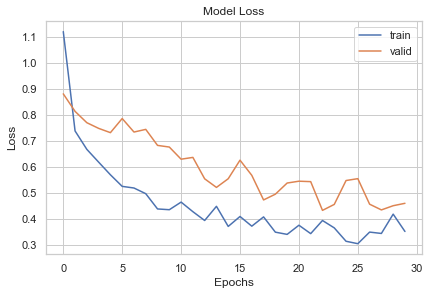

In [114]:
#Evaluating the Model Performance
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'valid'])
plt.show()

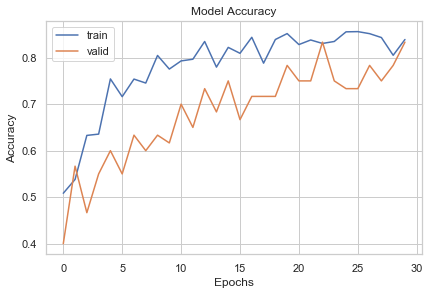

In [115]:
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'valid'])
plt.show()

In [103]:
test_loss, test_acc = model.evaluate(test_img, test_label)

25/25 [==============================] - 1s 32ms/step


In [105]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.6800000071525574
Test accuracy: 0.4326096773147583


In [46]:
# getting predictions on val set.
pred=model.predict(test_img)
pred_digits=np.argmax(pred,axis=1)

In [110]:
#To test for the given single input
im1=cv2.imread('container13.jpg')
img = im1.reshape(1,64,64,3)
pred=model.predict(img)
pred_digits=np.argmax(pred,axis=1)

"[['cover']]"

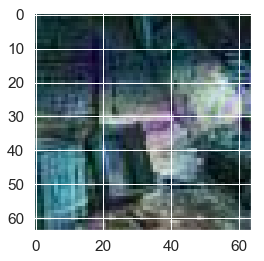

In [111]:
fig1,ax1=plt.subplots(1,1)
ax1.imshow(im1)
str(le.inverse_transform([pred_digits]))

In [49]:
#Importing Various Modules
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
def img_read(folder):
    images = []
    original_img = []
    for filename in os.listdir(folder):
        im1 = cv2.imread(os.path.join(folder,filename))
        if im1 is not None:
            original_img.append(im1)
            img = im1.reshape(1,64,64,3)
            images.append(img)
    return images,original_img

1
0
0
0
0
0
0
1
0
0
0
0
1
1
0
1
0
0
0
0


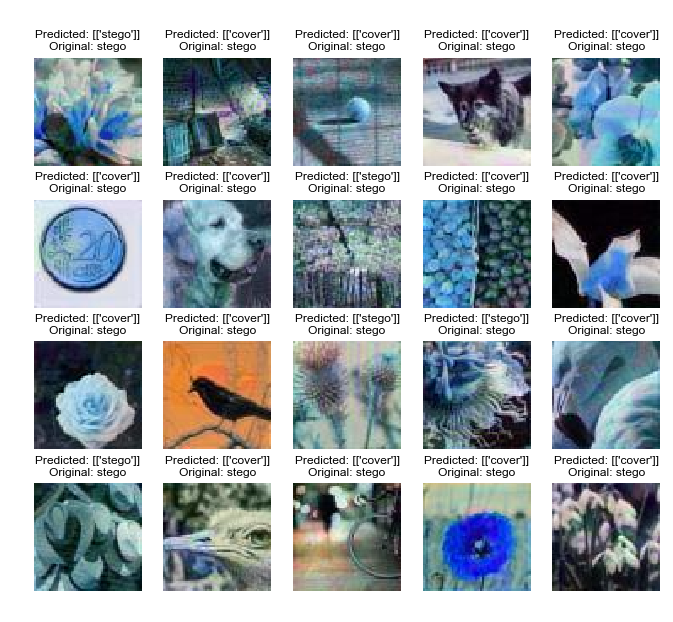

In [92]:
n = 21
# setting values to rows and column variables
rows = 4
columns = 5
predicted = []
actual = []
folder = 'F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing_new/test/stego'
words = folder.split("/")
word = words[-1]
%matplotlib inline 
fig = plt.figure(figsize=(10, 10))
for i in range(1,n):
    a, b = img_read(folder)
    pred=model.predict(a[i])
    pred_digits=np.argmax(pred,axis=1)
    int_arr = np.asscalar(pred_digits)
    if int_arr == 1:
        ir = "stego"
    else:
        ir = "cover"
    predicted.append(ir)
    print(int_arr)
    if word == 'stego':
        actual.append(word)
    else:
        actual.append(word)
    fig.add_subplot(rows,columns,i)
    plt.imshow(b[i])
    plt.axis('off')
    plt.title("\n\n"+"Predicted: "+str(le.inverse_transform([pred_digits]))+"\n"+"Original: "+word,**title_font)  
plt.show()

0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
1
0
1
0
1


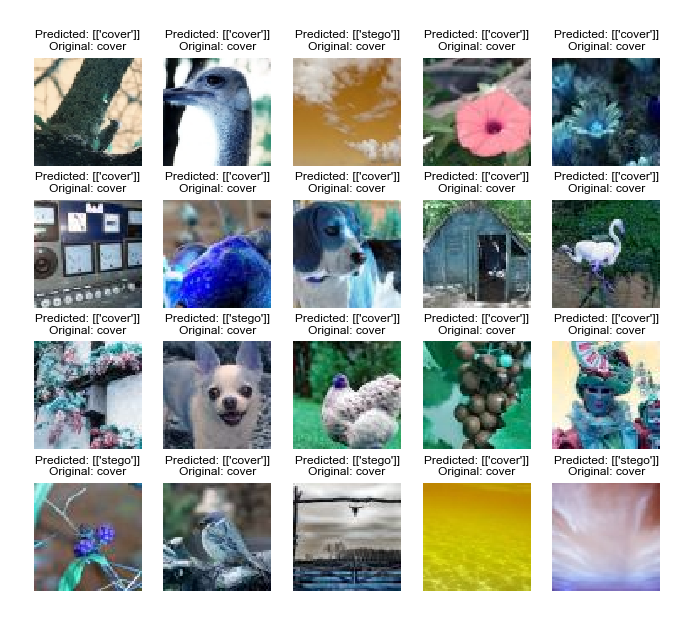

In [93]:
n = 21
# setting values to rows and column variables
rows = 4
columns = 5
folder = 'F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing_new/test/cover'
words = folder.split("/")
word = words[-1]
%matplotlib inline 
fig = plt.figure(figsize=(10, 10))
for i in range(1,n):
    a, b = img_read(folder)
    pred=model.predict(a[i])
    pred_digits=np.argmax(pred,axis=1)
    int_arr = np.asscalar(pred_digits)
    if int_arr == 1:
        ir = "stego"
    else:
        ir = "cover"
    predicted.append(ir)
    print(int_arr)
    if word == 'stego':
        actual.append(word)
    else:
        actual.append(word)
    fig.add_subplot(rows,columns,i)
    plt.imshow(b[i])
    plt.axis('off')
    plt.title("\n\n"+"Predicted: "+str(le.inverse_transform([pred_digits]))+"\n"+"Original: "+word, **title_font)  
plt.show()

In [94]:
import pandas as pd
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predicted, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("Test set confusion matrix \n")
print(df_confusion)

Test set confusion matrix 

Predicted  cover  stego  All
Actual                      
cover         15      5   20
stego         15      5   20
All           30     10   40


Test set confusion matrix


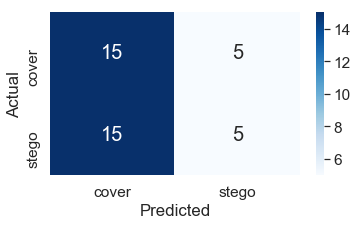

In [95]:
print("Test set confusion matrix")
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(actual,predicted)
df_cm = pd.DataFrame(data, columns=np.unique(actual), index = np.unique(predicted))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20})# font size

In [119]:
a = confusion_matrix(actual,predicted)
print('\nConfusion Matrix of test set')
print('\nTrue Positive       = ', a[1][1])
print('True Negative       = ', a[0][0])
print('False Positive      = ', a[0][1])
print('False Negative      = ', a[1][0])


Confusion Matrix of test set

True Positive       =  5
True Negative       =  15
False Positive      =  5
False Negative      =  15


In [97]:
from sklearn import metrics
print("Test set")
print(metrics.classification_report(actual, predicted, labels=["cover","stego"]))

Test set
             precision    recall  f1-score   support

      cover       0.50      0.75      0.60        20
      stego       0.50      0.25      0.33        20

avg / total       0.50      0.50      0.47        40



In [56]:
title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space

0
0
0
0
0
0
0
1
0
0
1
0
1
0
1
0
0
1
0
0


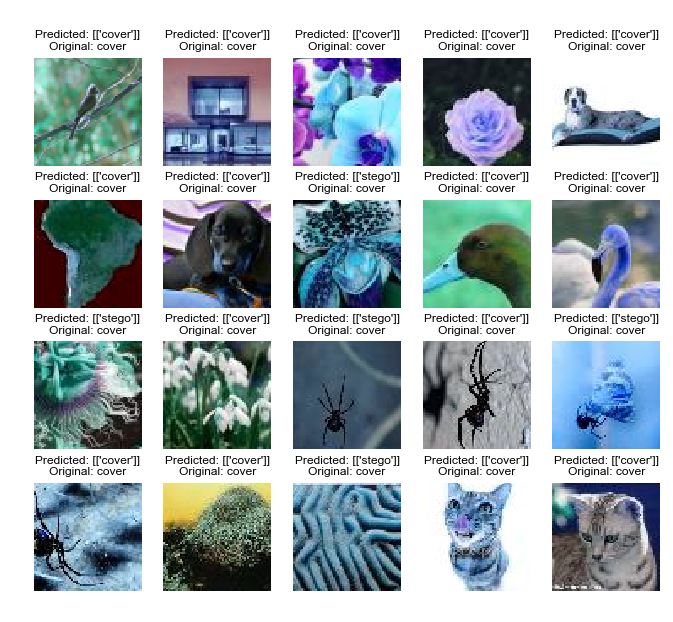

In [70]:
n = 21
# setting values to rows and column variables
rows = 4
columns = 5
actual_v = []
predicted_v = []
folder = 'F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing_new/valid/cover'
words = folder.split("/")
word = words[-1]
%matplotlib inline 
fig = plt.figure(figsize=(10, 10))
for i in range(1,n):
    a, b = img_read(folder)
    pred=model.predict(a[i])
    pred_digits=np.argmax(pred,axis=1)
    int_arr = np.asscalar(pred_digits)
    if int_arr == 1:
        ir = "stego"
    else:
        ir = "cover"
    predicted_v.append(ir)
    print(int_arr)
    if word == 'stego':
        actual_v.append(word)
    else:
        actual_v.append(word)
    fig.add_subplot(rows,columns,i)
    fig.add_subplot(rows,columns,i)
    plt.imshow(b[i])
    plt.axis('off')
    plt.title("\n\n"+"Predicted: "+str(le.inverse_transform([pred_digits]))+"\n"+"Original: "+word,**title_font)  
plt.show()

1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1


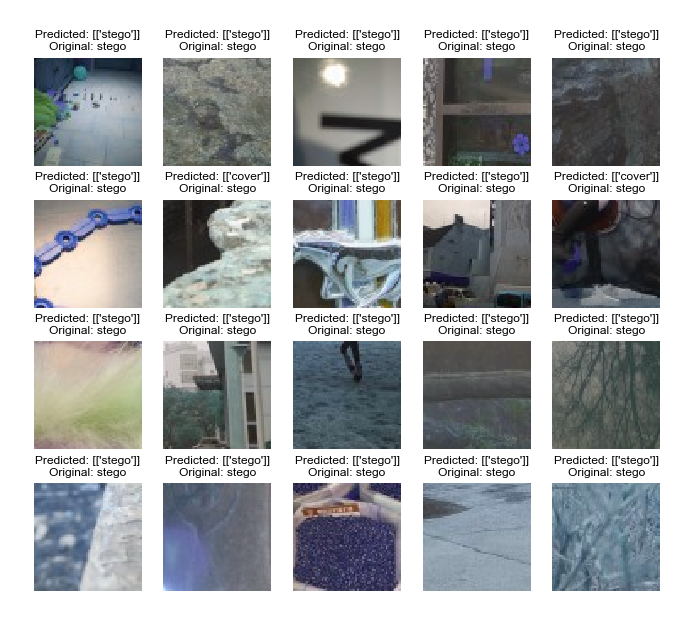

In [71]:
n = 21
# setting values to rows and column variables
rows = 4
columns = 5
folder = 'F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing_new/valid/stego'
words = folder.split("/")
word = words[-1]
%matplotlib inline 
fig = plt.figure(figsize=(10, 10))
for i in range(1,n):
    a, b = img_read(folder)
    pred=model.predict(a[i])
    pred_digits=np.argmax(pred,axis=1)
    int_arr = np.asscalar(pred_digits)
    if int_arr == 1:
        ir = "stego"
    else:
        ir = "cover"
    predicted_v.append(ir)
    print(int_arr)
    if word == 'stego':
        actual_v.append(word)
    else:
        actual_v.append(word)
    fig.add_subplot(rows,columns,i)
    fig.add_subplot(rows,columns,i)
    plt.imshow(b[i])
    plt.axis('off')
    plt.title("\n\n"+"Predicted: "+str(le.inverse_transform([pred_digits]))+"\n"+"Original: "+word,**title_font)  
plt.show()

In [72]:
import pandas as pd
y_actu = pd.Series(actual_v, name='Actual')
y_pred = pd.Series(predicted_v, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("Validation set confusion matrix \n")
print(df_confusion)

Validation set confusion matrix 

Predicted  cover  stego  All
Actual                      
cover         15      5   20
stego          2     18   20
All           17     23   40


Validation set confusion matrix


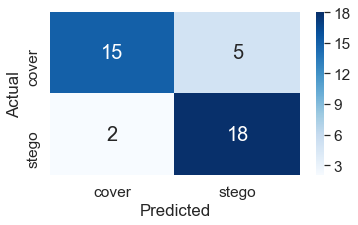

In [73]:
print("Validation set confusion matrix")
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(actual_v,predicted_v)
df_cm = pd.DataFrame(data, columns=np.unique(actual_v), index = np.unique(predicted_v))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20})# font size

In [74]:
a = confusion_matrix(actual_v,predicted_v)
print('\nConfusion Matrix of validation set')
print('\nTrue Possitive    = ', a[1][1])
print('True Negative     = ',   a[0][0])
print('False Possive     = ',   a[0][1])
print('False Negative    = ',   a[1][0])


Confusion Matrix of validation set

True Possitive    =  18
True Negative     =  15
False Possive     =  5
False Negative    =  2


In [75]:
from sklearn import metrics
print("Validation set")
print(metrics.classification_report(actual_v, predicted_v, labels=["cover","stego"]))

Validation set
             precision    recall  f1-score   support

      cover       0.88      0.75      0.81        20
      stego       0.78      0.90      0.84        20

avg / total       0.83      0.82      0.82        40

